# Setup

In [1]:
import nltk
import time
import re
import numpy as np
import pandas as pd
import twint
import json
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools FOR TOPIC MODELING
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional  (I HAVEN'T USED THIS YET)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words -------------- ADD TO THESE AS WE SEE FIT
from nltk.corpus import stopwords

import pickle

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

# TWINT SCRAPING FROM TWITTER 

---

SEE https://github.com/twintproject/twint for options. The following cell returns a .csv file from all tweets containing 'Coronavirs' since the time specified by the [--since] option, in the [--lang] of english (en), and the csv file gets named after whatever iteration of scraping it is plus useful search parameters in the file name.


---

In [2]:
# THE TWINT COMMAND I USE IN TERMINAL TO SCRAPE

# twint -s Coronavirus --since "2020-03-24 20:00:00" --lang en -o just_cv_en_2 --csv

# Importing and Prepocessing 

---

**Open the corpus_pipeline to make changes, I'm sure there's lots of ways to clean tweets beyond simply regexing for emails and new line characters, probably way more preprocessing we can do, especially with .extending the stopwords.**

---

In [3]:
df3 = pd.read_csv('./just_cv/twint_3_en.csv')

In [4]:
df3.shape

(14400, 34)

In [5]:
df4 = pd.read_csv('./just_cv/twint_4_en.csv')

In [6]:
df4.shape

(14399, 34)

In [7]:
df5 = pd.read_csv('./just_cv/twint_5_en.csv')

In [8]:
df5.shape

(14399, 34)

In [9]:
df6 = pd.read_csv('./just_cv/twint_6_en.csv')

In [10]:
df6.shape

(14399, 34)

In [11]:
df7 = pd.read_csv('./just_cv/twint_7_en.csv')

In [12]:
df7.shape

(14400, 34)

In [13]:
df8 = pd.read_csv('./just_cv/twint_8_en.csv')

In [14]:
df8.shape

(13719, 34)

In [15]:
data3 = df3.tweet.values

In [16]:
data4 = df4.tweet.values

In [17]:
data5 = df5.tweet.values

In [18]:
data6 = df6.tweet.values

In [19]:
data7 = df7.tweet.values

In [20]:
data8 = df8.tweet.values

In [21]:
data = np.concatenate([data3, data4, data5, data6, data7, data8])

In [22]:
data.shape

(85716,)

In [23]:
data

array(['I said they are better than nothing, not that they are as good as the medical ones. There was no "bare face" group to fully show how effective the cloth masks are. The cloth masks are not meant to protect you from coronavirus, they are there to catch at least some of the 1/2',
       'Oops: CNN Forgot To Translate Its Latest Coronavirus Update From Mandarin |   https://babylonbee.com/news/cnn-embarassed-after-forgetting-to-translate-latest-coronavirus-update-from-mandarin-before-publishing\xa0…',
       'Speeding up https://twitter.com/ryanfiredragon/status/1242886374963007493\xa0…',
       ...,
       'Maybe, his death will save the lives of his congregation. Covid19 is not a hoax.\n#CoronaVirus  https://twitter.com/cherijacobus/status/1243347684385271808\xa0…',
       'y’all go watch this corona virus movie,it was released in 2018 .Episode 10  pic.twitter.com/GE0eVfqKQY',
       '@USDOL just released this to workplaces across the US. #KnowYourRights #Coronavirus #COVID19 #USD

In [24]:
types = []
for i in data:
    types.append(type(i))

In [25]:
index = 0
non_str = {}
fake = []
for i in data: 
    if type(i) != str:
        non_str[index] = type(i)
    index += 1

In [26]:
for i in non_str:
    data = np.delete(data, i)

In [27]:
df = pd.DataFrame()

df['tweets'] = data

In [28]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

df['sentiment'] = [analyser.polarity_scores(i) for i in df['tweets']]

df['compound_sentiment'] = [i['compound'] for i in df['sentiment']]
df['sentiment'] = df['compound_sentiment']
df.drop(columns=['compound_sentiment'], inplace=True)

In [29]:
filtered_sentiment_df = df.loc[(df['sentiment'] < -.40) ^ (df['sentiment'] > .40)]

In [30]:
data = filtered_sentiment_df.tweets.values

In [31]:
more = ["news","case","make","would","death","spread","story","still","stop","kill","com", "twitter","pic","say","https"]
more2 = ["help","work","time","new","covid","get","test","day","http","country","good","world","may","government","pat", 'virus']
more3 = ["due","stay","be","report","worker","bill","back","first","people","corona", 'saying', 'getting', 'pandemic', 'state', 'china', 'covid19']
more4 = ["go","die","take","see","know","status","call",'Go','Say', 'www', 'many', 'see', 'make', 'want', 'be', 'could', "s", 'tell', 'today']
more5 = ['Let', 'being', 'going','case', 'make', 'also', 'let', 'coronavirus', 'Coronavirus', 'Corona', 'must', 'much', 'thing', 'keep', 'even']
more6 = ['need', 'like', 'one', 'thank', 'html', 'covid2019', 'getting', 'making', 'coming', 'saying']


In [32]:
more.extend(more2)

In [33]:
more.extend(more3)

In [34]:
more.extend(more4)

In [35]:
more.extend(more5)

In [36]:
more.extend(more6)

In [37]:
stop_words = stopwords.words('english')

In [38]:
len(more)

91

In [39]:
len(stop_words)

179

In [40]:
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [41]:
stop_words.extend(more)

In [42]:
len(stop_words)

275

**The following returns the [id2word] dictionary, [texts] which is the lemmatized data, and [corpus] which is the corpus.**

In [43]:
def corpus_pipeline(data):  
    # ********    THE FOLLOWING REGEXES SHOULD PROBABLY BE HEAVILY MODIFIED FOR CUSTOMIZING TWEETS CLEANING  *************
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    data_words = list(sent_to_words(data))

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # **********   ALSO PROBABLY REQUIRES EXTENSIVE ADDING OF TWEET-SPECIFIC STOPWORDS   ***********
    # Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    
    data_words_trigrams = make_trigrams(data_words_bigrams)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    nlp = spacy.load('en', disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    return id2word, texts, corpus

# Pipeline for Dict, Texts, Corpus

In [44]:
id2word, texts, corpus = corpus_pipeline(data)

# LDA Model

In [45]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [46]:
lda_model.show_topics()

[(0,
  '0.029*"not" + 0.020*"do" + 0.018*"home" + 0.017*"health" + 0.013*"hospital" + 0.012*"good" + 0.011*"be" + 0.011*"follow" + 0.011*"loom" + 0.011*"proceed"'),
 (1,
  '0.029*"case" + 0.020*"say" + 0.010*"number" + 0.010*"dramatic" + 0.009*"think" + 0.009*"give" + 0.008*"life" + 0.008*"video" + 0.008*"confirm" + 0.008*"deal"'),
 (2,
  '0.039*"trump" + 0.019*"aid" + 0.017*"crisis" + 0.011*"improvement" + 0.011*"outbreak" + 0.010*"response" + 0.009*"usa" + 0.009*"fight" + 0.009*"america" + 0.009*"bad"'),
 (3,
  '0.027*"s" + 0.015*"president" + 0.015*"show" + 0.015*"patient" + 0.014*"get" + 0.011*"live" + 0.011*"watch" + 0.010*"right" + 0.009*"app" + 0.008*"united_state"'),
 (4,
  '0.019*"have" + 0.019*"worry" + 0.018*"away" + 0.014*"lung" + 0.013*"cut" + 0.012*"aka" + 0.011*"put" + 0.010*"risk" + 0.010*"break" + 0.010*"infect"')]

# Topic Assignment to Original Tweets

In [48]:
final_topics = []
for i in corpus:  
    topics = lda_model.get_document_topics(i)

    probs = {}
    for i in topics:
        probs[i[0]] = i[1]

    topic = max(probs, key=probs.get)
    final_topics.append(topic)

In [49]:
len(final_topics)

41203

In [50]:
df_final = filtered_sentiment_df.copy()

In [51]:
df_final['topic'] = final_topics

In [52]:
topic_dict = {0: 'public_health',
              1: 'boris',
              2: 'economy',
              3: 'trump',
              4: 'employment'}

In [53]:
df_final['topic_defined'] = df_final.topic.apply(lambda x: topic_dict[x])

In [54]:
df_final

,tweets,sentiment,topic,topic_defined
0,"I said they are better than nothing, not that ...",0.6984,0,public_health
3,"Texas Gov. Greg Abbott, who routinely overrule...",0.6369,1,boris
4,"Other than Satan, is there anyone more evil th...",-0.6901,1,boris
5,Doctors say vitamin D3 may be helpful in comba...,0.6124,1,boris
6,JUST IN: COVID-19: Edo Speaker tests positive ...,0.5574,1,boris
...,...,...,...,...
85701,Coronavirus probably scared of catching you.,-0.4404,1,boris
85706,Since you liked that photo of me with my hands...,0.6908,0,public_health
85707,#rp aka #mj .:) please stay away from #coronav...,0.5621,0,public_health
85710,RT to tell ⁦@USAID⁩ to stop aid cuts to Yemen....,-0.6124,0,public_health


In [55]:
df_final.groupby('topic_defined')['sentiment'].describe()

,count,mean,std,min,25%,50%,75%,max
topic_defined,,,,,,,,
boris,15571.0,-0.041260,0.649512,-0.9951,-0.63490,-0.4215,0.5859,0.9920
economy,10648.0,-0.203741,0.627789,-0.9950,-0.70440,-0.5106,0.4939,0.9996
employment,913.0,-0.236359,0.588353,-0.9879,-0.65310,-0.5106,0.4588,0.9380
public_health,10307.0,0.144362,0.639765,-0.9919,-0.55740,0.4588,0.6705,0.9921
trump,3764.0,0.072284,0.647804,-0.9780,-0.58515,0.4215,0.6369,0.9892


In [56]:
trump = df_final.loc[(df_final.topic_defined == 'trump')]

In [57]:
worst5vals = sorted(trump.sentiment)[10]
worst5vals

-0.9501

In [58]:
trump_worst_5 = trump.loc[trump.sentiment < worst5vals]

In [59]:
trump_worst_5.tweets.values

array(["@RudyHavenstein Our new pet\nSing-a-long with us!\nWinnie the Flu, Winnie the Flu,\nClucky, little sucky all stuffed with mucky.\nHe's Winnie the Flu, Winnie the Flu,\nClingy, stingy, nasty new flu.\n#coronavirus  pic.twitter.com/UupZVFxhxr",
       "Perfect for anti-vaxxers! Sick of waiting for measles to kill or permanently scar your child? Tired of giving them a virus that'll stay in their body as they age and then cause them constant pain? Just give 'em coronavirus and give them a slow, painful death directly!  https://twitter.com/beyerstein/status/1242842580347428864\xa0…",
       "Glenn Beck: 'I'd rather die' from coronavirus 'than kill the country' from economic shutdown  https://thehill.com/homenews/media/489472-glenn-beck-id-rather-die-from-coronavirus-than-kill-the-country-from-economic#.XnwZrYBbd9U.twitter\xa0… via @thehill #US #Politics #COVIDー19 WT_ #FoxNews @FoxNews Fired #GlennBeck Years Ago!Revive #TeaParty #NeoCons #Children #Sick #Die-Too #Old! #Trump #Economy

In [60]:
best5vals = sorted(trump.sentiment, reverse=True)[30]

In [61]:
trump_best_5 = trump.loc[trump.sentiment > best5vals]

In [62]:
trump_best_5.tweets.values

array(["Thank you @JackMa for helping us out, Many thanks to our President for maintaining good relations with such good friends @China_Amb_Zim @ChineseZimbabwe, a friend in need is a friend in deed👏👏, let's fight #coronavirus\n#Covid_19\n@JonesMusara @ZANUPF_Official @TafadzwaMugwadi pic.twitter.com/BUAFjOVNCo",
       " http://youtu.be/azSDiJ5G9U8\xa0\nI am so happy to share with y'all this comedy love song!  We made this all while being self quarantined!  Hoping we can provide a little humor during this stressful time.  #quarantinekiller #comedy #music #coronavirus #StayHome",
       "Let's fight with #coronavirus by positive spirit.😀\nWe can win over #corona virus by #selfisolating awareness,stop #FakeNews & by creative positive sharing🙏\n@narendramodi @drharshvardhan\n#JantaCurfew #CoronaUpdatesInIndia #IndiaFightsCorona #COVID19 https://youtu.be/wBxr26l2OGs\xa0",
       'The only absolute positive about coronavirus is the impact it has had on the launch of ‘just Harry and Meghan’

In [63]:
boris = df_final.loc[(df_final.topic_defined == 'boris')]

In [64]:
worst30vals = sorted(boris.sentiment)[30]
worst30vals

-0.9712

In [65]:
boris_worst_30 = boris.loc[boris.sentiment < worst30vals]

In [66]:
boris_worst_30.tweets.values

array(['All everybody focused on is making a cure for the corona virus n I want somebody to grow weed that’ll keep me high for 24 hrs 😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭',
       'Department of health is covering up the first coronavirus death so they don’t scare tourists. How the hell do you fuck up that bad? Bruce Anderson and Sarai park both have to go. Take ige’s ass and Caldwell with them too.',
       'مع * Maariv: *\n Italy records 683 new deaths during the past 24 hours of the Corona virus, bringing the number of deaths there from the virus to 7,503\n😭😭😭😭😭😭😭😭😭😭😭😭😭😭',
       "IS PUNJAB GOING TO B CORONA VIRUS HOTSPOT IN INDIA WITH FLOODING NRI 'S ROAMING AROUND WITHOUT QUARANTINE 😱😱😱😱😱 https://www.facebook.com/355665009819/posts/10158164846819820/?sfnsn=wiwspmo&extid=fl1x8UcZdxCrsypV\xa0…",
       'Coronavirus can kill a human too quickly but it can’t kill hatred. That’s one mean bitch!',
       'Angry angry angry \n\n😠😠😠😠😠😠😠😠\n‘Disgraceful’ landlords hold secret prohibition-style pub lock-ins to

In [67]:
best30vals = sorted(boris.sentiment, reverse=True)[30]

In [68]:
best30vals

0.967

In [69]:
boris_best_30 = boris.loc[boris.sentiment > best30vals]

In [70]:
boris_best_30.tweets.values

array(['The novel coronavirus may be strong, but our community is stronger. Have you witnessed an act of kindness in your community? No matter how big or small, share it with us using #CommunityGreaterThanCovid19.\nEach entry will be entered into a draw to win a $100 Amazon gift card. pic.twitter.com/hUPE2YDtKX',
       'Lets unite to forget #coronavirus\n🖕🖕U #ChineseVirus\n@realDonaldTrump 🤣🤣🤣\n\nFav Movie; #7amarivu\n( @ARMurugadoss)\n Fav song : #venpanimalarae(#powepandi)\nFav color : #white\nFav actor: @Suriya_offl\nFav Drink : #datesmilkshake\n\nI nominate @arya_offl @VigneshShivN #)@sayyeshaa https://twitter.com/MASTERMiiiiiND/status/1242881837820596224\xa0…',
       'Pray the Holy Rosary daily for the graces from God to meet the challenges of the "coronavirus" in Our Country & the whole world.May the Blessed Mother intercede for us with God to be patient, civil, respectful, honest, & cooperative with the many civil inconveniences with WISDOM!',
       "I like your pretty little

In [71]:
economy = df_final.loc[(df_final.topic_defined == 'economy')]

In [72]:
worst30vals = sorted(economy.sentiment)[30]
worst30vals

-0.9699

In [73]:
economy_worst_30 = economy.loc[economy.sentiment < worst30vals]

In [74]:
economy_worst_30.tweets.values

array(["Mother is mother, this is not the time to fight among themselves, It's time to fight together with coronavirus, Let me tell you once, there is still time to stop the fight right now & no one will abuse someone's religion, abuse someone's mother and outrage someone's community!!❌",
       '#POLITICIANS and #Media #Advertising ... EXPLOITING people ...interrupting normal programing for the same BS. Use your normal news hour for this crap! We get it you MORONS. STOP the non-STOP coronaVIRUS crap. We get it ... OMG! It is SICKENING you are making people SICK!',
       'Feb 2020\nDonald Trump FLOODING 🇺🇸\nDAILY With #coronavirus LIES\n\nVirus is a HOAX from Dems to hurt Trump\nVirus will mysteriously go away\nI have it CONTROLLED\nFLU kills MORE👥\n\nTrump was WARNED of PANDEMIC, HE IGNORED\nWARNINGS\n\nYou a journalist, FLOODING 🇺🇸 with Trump Lies',
       'What this pandemic is showing is the crudest inequalities and violence of our  broken systems. So sad to read this news: "Colom

In [75]:
best30vals = sorted(economy.sentiment, reverse=True)[30]

In [76]:
best30vals

0.9536

In [77]:
economy_best_30 = economy.loc[economy.sentiment > best30vals]

In [78]:
economy_best_30.tweets.values

array(['COVID-19 Coronavirus Advisory 25/03/20\nAfter briefly closing to ensure we both met and well exceeded the social distancing rules at work, we have now re-opened. Please see website for full details.\nWe wish you all the best and hope you remain safe and well.  pic.twitter.com/25LJSlvIsp',
       '😂😂😂 And Lou Dobbs poll results show REALLY STRONG support for Trump’s handling of coronavirus. It’s at 100% #MAGAts #COVIDIDIOT',
       '🔹🔹🔹🔹🔹🔹🔹🔹🔹\n\nWell, here we go!! \n\nNOW PRINCE CHARLES TESTS POSITIVE FOR #CORONAVIRUS \n\nWe KNEW THIS was coming!!\n\n🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹  https://twitter.com/chrisshipitv/status/1242761154973368320\xa0…',
       "😂😂😂😂😂 Pfister,  let's hope by nature as well now inside\n\n#coronacunt\n#coronavirus  https://twitter.com/stillgray/status/1242630562285670400\xa0…",
       "You drink bitters ? Yes, but it's not the cure to coronavirus. Where's the herbalist? He's swindled me. 😂😂😂😂  pic.twitter.com/rrkf0aVxpZ",
       '😂😂😂 same hereeee.. I was likegirl, where hav

In [79]:
ph = df_final.loc[(df_final.topic_defined == 'public_health')]

In [80]:
ph

,tweets,sentiment,topic,topic_defined
0,"I said they are better than nothing, not that ...",0.6984,0,public_health
22,Its official. Coronavirus has reached Nacogdoc...,0.6486,0,public_health
24,WASHING YOUR HANDS IS GOOD BUT IS IT ENOUGH TO...,0.6084,0,public_health
28,Huge thanks to Dr Tosin who kindly did a Q&A w...,0.9531,0,public_health
33,I'm intrigued to learn more about the spread o...,0.7778,0,public_health
...,...,...,...,...
85692,"To all Nurses and Doctors,\nThank You.\nfor al...",0.8316,0,public_health
85696,"Without research, you can't know what the trut...",-0.5709,0,public_health
85706,Since you liked that photo of me with my hands...,0.6908,0,public_health
85707,#rp aka #mj .:) please stay away from #coronav...,0.5621,0,public_health


In [81]:
worst30vals = sorted(ph.sentiment)[30]
worst30vals

-0.9618

In [82]:
ph_worst_30 = ph.loc[ph.sentiment < worst30vals]

In [83]:
ph_worst_30.tweets.values

array(['People who are negative, or have negative minds are affected by the virus most drastically. They imagine the worst case scenarios (very possibly) and being in fear of the virus can kill them selves through panic and their beliefs. #coronavirus',
       "pic: im your pillow and im sick and tired of you crying over your stupid fucking ex, it's annoying and im tired of getting wet. it's gross",
       "Prince Charles Coronavirus diagnosis: Charles will be feeling 'anxious' – Dr David Bull  http://shr.gs/gGv2nVV\xa0\nHe's had his arse wiped by Joe Public for 70 years! No doubt now it'll be Harley Street Specialists door to door & all within 6 feet! Privileged PRICK! 😠😠😠😠😠😠",
       "Israel kills cancer patients: \nIsraeli inhumane policies against Palestinian kids.\nCancer stricken Miral Abu Amsha, 10, had her medical treatment delayed on purpose by Israel, and then Israel denied her parents' visit. RIP.\n#coronavirus  pic.twitter.com/8iKx9lUg0q",
       'WATCH OUT\nThis is the cra

In [84]:
best30vals = sorted(ph.sentiment, reverse=True)[30]

In [85]:
best30vals

0.9682

In [86]:
ph_best_30 = ph.loc[ph.sentiment > best30vals]

In [87]:
ph_best_30.tweets.values

array(['Thank you my dear baby girl.\U0001f970\U0001f970\U0001f970💜🙏🏽  God bless you Arya . Love you to my dear. \n#We will stop #CORONAVIRUS. #world\n#Godisgood #COVID19 pic.twitter.com/kVoGmWL5tC',
       "Wow. All over the Twitter? I just came online to check Corona virus news ohh. I saw abegg Trending 🤣😂🤣🤣 account, send, share. A'ah. Is the party over?? I really need me some 10million ohhh....abi e too much?",
       'Yes. Yes. \n"We the People of the United States, in Order to form a more perfect Union: \nPromote the general Welfare, and secure the Blessings of Liberty. \nHow will we secure the Blessings of Liberty if touched by #coronavirus. \nWe are worried about 2020 rather General Welfare',
       'We urge you to be home guys. We know the travel is being hardly hit and we travel lovers are surely not in a good place. But, the best place now is home. So follow the orders, be safe. Take care :) #Covid19 #coronavirus #StayHome #traveldarji #tailoringjourneys pic.twitter.com/Xg57s

In [88]:
emp = df_final.loc[(df_final.topic_defined == 'employment')]

In [89]:
worst30vals = sorted(emp.sentiment)[30]
worst30vals

-0.9001

In [90]:
emp_worst_30 = emp.loc[emp.sentiment < worst30vals]

In [91]:
emp_worst_30.tweets.values

array(['5) no 1 is questioning d govt on hw d chinese corona virus infected ppl creeped into india widout detection & hw they infected others.\nThis govt is distracting ppl by lockdown and panic creation to hide its mismanagement mistake,failure to detect corona,failure in foreign affairs',
       'UPDATE: Wicked Democrat Governor Sisolak WILL ALSO NOT ALLOW Nevadans to Prescribe Chloroquine as a Preventative Against the Coronavirus  https://www.thegatewaypundit.com/2020/03/update-wicked-democrat-governor-sisolak-will-also-not-allow-nevadans-to-purchase-chloroquine-as-a-preventative-against-the-coronavirvia\xa0… @gatewaypundit Who the hell does he think he is?This isn’t a dictatorship!! He should be kicked out of office by force!',
       "What worries me re #coronavirus is it's highly contagious, spreads rapidly in congested settings: nursing homes, prisons, hosps. I worry about health workers & scarcity of med supplies. Death rate not fully known but higher than flu. I worry also abo

In [92]:
best100vals = sorted(emp.sentiment, reverse=True)[100]

In [93]:
best100vals

0.6671

In [94]:
emp_best_100 = emp.loc[emp.sentiment > best100vals]

In [95]:
emp_best_100.tweets.values

array(['Just published: Ahead-of-the-curve special report by @sxbegle:\n When can we let up? Health experts craft strategies to safely relax #coronavirus lockdowns \n\n https://bit.ly/2JdzLDh\xa0 via @statnews',
       'Launching soon: \n@coronacarecard\n With literally five clicks, you can help your favorite local business weather the coronavirus storm by buying a digital gift card or giving them a tip #coronacarecard',
       'To the lady who came into my Pcy today &coughed (without covering ur mouth) insisting u don’t have Coronavirus (it’s just a chest infection!)think before you leave your house. Swallow your pride & ask for help.Get a friend to collect ur meds. Don’t think u r ok & be a risk to us',
       'Back at it again! After a frustrating night in Corona Virus Mountain, I will attempt to put Super Mario Sunshine on the shelf for good tonight. And who knows, there might be some extra fun if I can beat the game quick enough! Join tonight at 8PM EST!\n\n http://twitch.tv/arsr\

# Visualizing and Findings

In [96]:
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

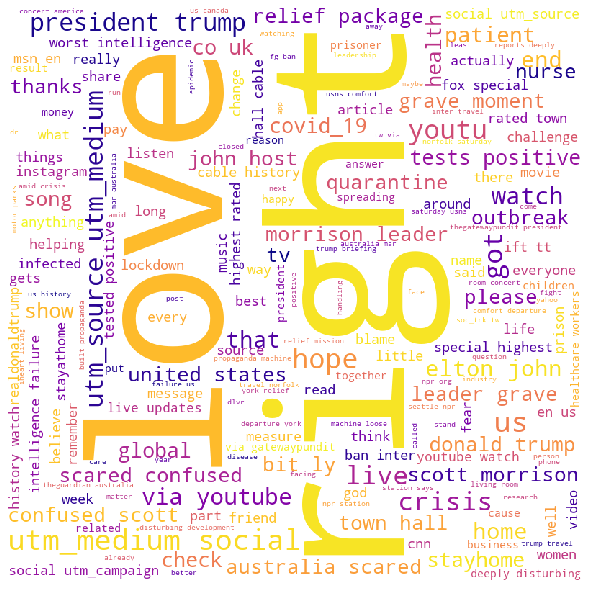

In [97]:

comment_words = ' '
stopwords = stop_words
  
# iterate through the csv file 
for val in trump.tweets: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                colormap = 'plasma').generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

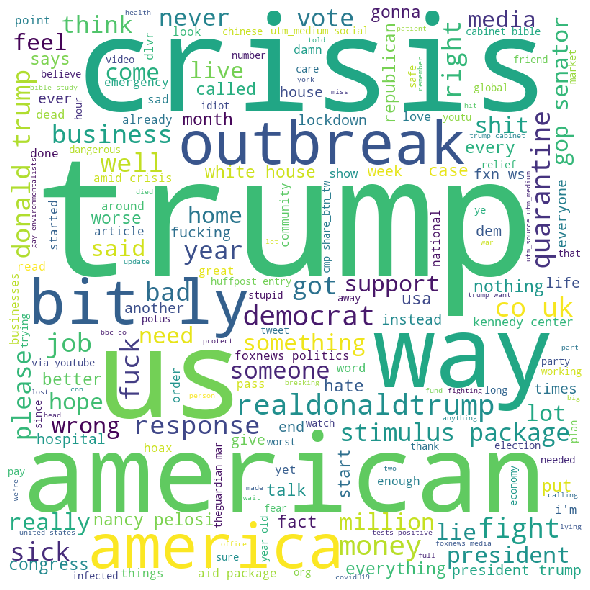

In [98]:

comment_words = ' '
stopwords = stop_words 
  
# iterate through the csv file 
for val in economy.tweets: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [99]:
boris.tweets.values

array(['Texas Gov. Greg Abbott, who routinely overrules big-city initiatives, has found an issue he thinks is best left to cities and towns: the new coronavirus  https://www.wsj.com/articles/texas-coronavirus-response-is-keep-it-local-as-more-states-move-to-lockdowns-11585148279\xa0… via @efindell for @WSJ',
       'Other than Satan, is there anyone more evil than @SpeakerPelosi? \n\n#StimulusPlan #COVID2019 #SwampCreature #DrainTheSwamp #CoronaVirus  pic.twitter.com/8J1QPXoY0V',
       'Doctors say vitamin D3 may be helpful in combating coronavirus.  pic.twitter.com/TrWOD3vhs1',
       ..., 'Weed might help ... pic.twitter.com/AxPUYIMLFe',
       'Coronavirus probably scared of catching you.',
       "For those of you who've been following Emma's story [the 12 yr old in #GA with #covid19].   She's doing much better.  Her lung scan show improvement & she's slowly coming out of sedation.  \nYEAH!  \n\n https://www.ajc.com/news/local-govt--politics/good-improvement-says-relative-year-old

In [100]:
comment_words = []
stopwords = stop_words 
  
# iterate through the csv file 
for val in boris.tweets.values: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      

    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    
    for words in tokens: 
        comment_words.append(words)
  

In [101]:
boris_fix = ' '.join(comment_words)

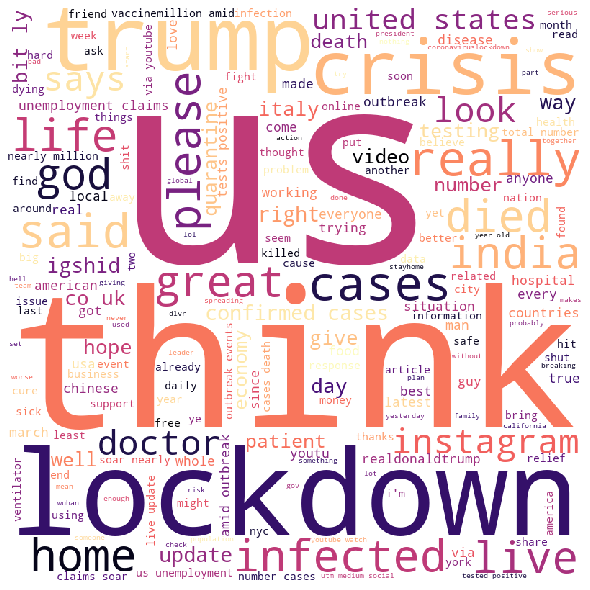

In [102]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                colormap='magma').generate(boris_fix) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [103]:
boris.tweets

3        Texas Gov. Greg Abbott, who routinely overrule...
4        Other than Satan, is there anyone more evil th...
5        Doctors say vitamin D3 may be helpful in comba...
6        JUST IN: COVID-19: Edo Speaker tests positive ...
11       Shaikh kindly do reply.. here in South Asia In...
                               ...                        
85693    wtf does $10k of student debt have to do with ...
85699    Meanwhile, the US hits 85,486 #Coronavirus cas...
85700       Weed might help ... pic.twitter.com/AxPUYIMLFe
85701         Coronavirus probably scared of catching you.
85711    For those of you who've been following Emma's ...
Name: tweets, Length: 15571, dtype: object

In [104]:
comment_words = []
stopwords = stop_words 
  
# iterate through the csv file 
for val in ph.tweets.values: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      

    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    
    for words in tokens: 
        comment_words.append(words)
  

In [105]:
ph_fix = ' '.join(comment_words)

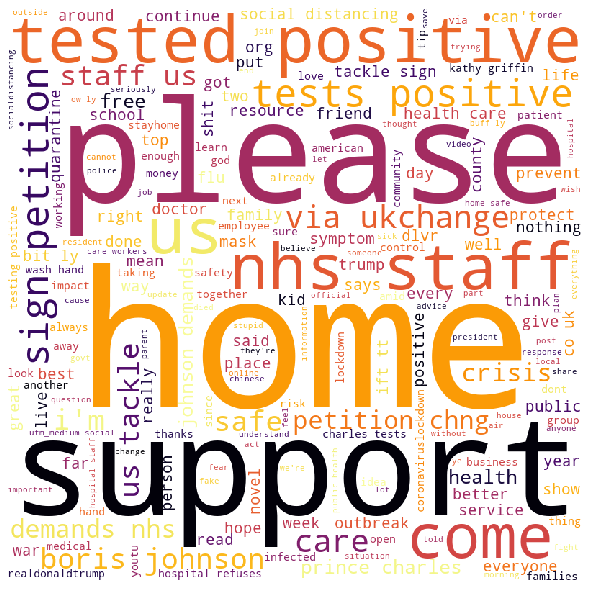

In [106]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                colormap = 'inferno').generate(ph_fix) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

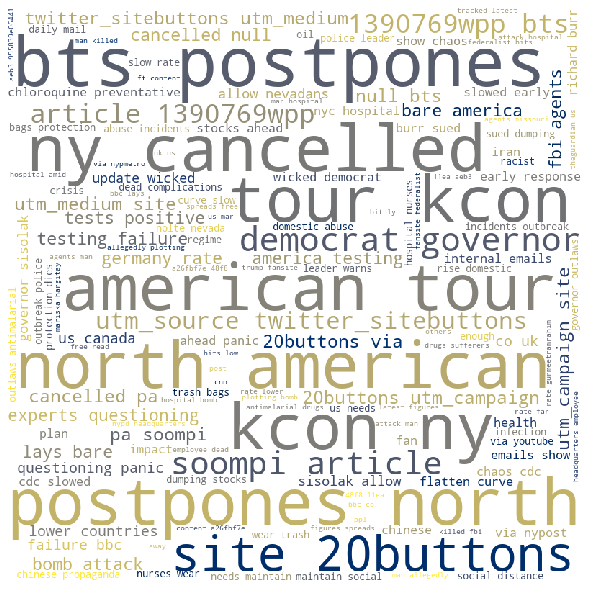

In [107]:

comment_words = ' '
stopwords = stop_words 
  
# iterate through the csv file 
for val in emp.tweets: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                colormap='cividis').generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Pickle

In [108]:
# Save a dictionary into a pickle file.
import pickle

In [109]:
pickle.dump(lda_model, open("lda_5_3456_best", "wb" ))

In [110]:
pickle.dump(corpus, open("corpus_best", "wb" ))

In [111]:
pickle.dump(id2word, open("id2word_best", "wb" ))

In [112]:
pickle.dump(texts, open("texts_best", "wb" ))

In [113]:
lda_model = pickle.load( open( "lda_5_3456_best", "rb" ) )
# favorite_color is now { "lion": "yellow", "kitty": "red" }d

In [114]:
corpus = pickle.load( open( "corpus_best", "rb" ) )
# favorite_color is now { "lion": "yellow", "kitty": "red" }d

In [115]:
id2word = pickle.load( open( "id2word_best", "rb" ) )
# favorite_color is now { "lion": "yellow", "kitty": "red" }d

In [116]:
texts = pickle.load( open( "texts_best", "rb" ) )
# favorite_color is now { "lion": "yellow", "kitty": "red" }d

([array([19.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([23.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([7., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([6., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([4., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([13.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([17.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([18.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([21.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([7., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([15.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([7., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([21.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([10.,

/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 22320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 27969 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 31354 missing from curren

/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2350 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2358 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 32722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 36817 missing from current f

/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 37101 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 25991 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 36149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2453 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2480 missing from current 

/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12525 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12490 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 22823 missing from curren

/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12451 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 33258 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 32102 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 36275 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12463 missing from curren

/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2341 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 25511 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21578 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20849 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 30149 missing from current

/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 45784 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 3585 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 3605 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 3634 missing from current font.
  f

/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12514 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12531 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12501 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12455 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12450 missing from current font.


/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 2326 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 2347 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 2360 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 2340 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 2351 missing from current font.
  fon

/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 119853 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 119841 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 119838 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 21475 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 32617 missing from current fon

/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 49828 missing from current font.


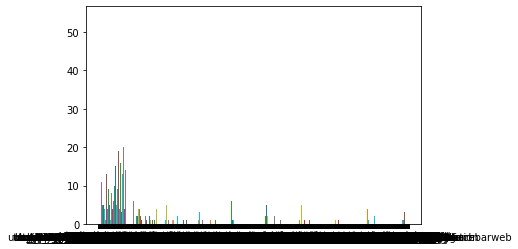

In [117]:
plt.hist(texts)